<a href="https://colab.research.google.com/github/anurag1210/llm-learning-anurag/blob/main/AI_Agents_Using_Langraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Loading the environment variables

import os
from openai import OpenAI
import re
import httpx


os.environ["OPENAI_API_KEY"]=""
os.environ["TAVILY_API_KEY"] = ""


In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated #For Agent States
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage#Langchain Message States used to represent human and AI in the system
from langchain_openai import ChatOpenAI #Langchain Wrapper
from langchain_community.tools.tavily_search import TavilySearchResults #Tavily is the search engine used to search for the tools

In [ ]:
#increased number of results, max result 2 means it will bring two results from the search API
tool = TavilySearchResults(max_results=42)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [ ]:
#Agent State

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [ ]:
#Creating an Agent

class Agent:

     #Inititalizing the Agent

    def __init__(self, model, tools, system=""):
      # Save the system prompt, if any, to guide the agent's behavior.
      self.system = system
      # Create a new stateful graph where AgentState defines the memory/state structure.
      graph = StateGraph(AgentState)
      # Add the first node "llm", which calls the language model (e.g., OpenAI).
      graph.add_node("llm", self.call_openai)
      # Add the second node "action", which handles taking an action (e.g., executing a tool).
      graph.add_node("action", self.take_action)
      # Add a conditional edge:
      # After calling the LLM, check if an action is needed.
      # If True → go to "action" node, otherwise → end the process.
      graph.add_conditional_edges(
          "llm",
          self.exists_action,           # Condition-checking function
          {True: "action", False: END}  # Define routing based on the result
      )
      # Add a simple edge to go back from "action" to "llm":
      # This creates a loop until no more actions are needed.
      graph.add_edge("action", "llm")
      # Define the entry point (first node to execute when the agent starts).
      graph.set_entry_point("llm")
      # Compile the graph into an executable object.
      self.graph = graph.compile()  # LangGraph executable agent logic
      # Create a dictionary of tools using their name as the key for easy lookup during tool execution.
      self.tools = {t.name: t for t in tools}
      # Bind the tools to the language model, enabling tool calling capabilities.
      self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
      # Extract the current list of messages from the agent's state.
      # These messages include the conversation history.
      messages = state['messages']
      # If a system prompt was defined during initialization, prepend it.
      # This helps guide the behavior of the LLM (e.g., tone, role, constraints).
      if self.system:
          messages = [SystemMessage(content=self.system)] + messages
      # Call the language model (e.g., OpenAI GPT) with the full message history.
      # `invoke` returns the LLM’s next response message.
      message = self.model.invoke(messages)
      # Return the updated message as a new state dictionary.
      # It replaces 'messages' with just the latest response from the model.
      return {'messages': [message]}

    def take_action(self, state: AgentState):
      print("Entering take_action...")
      tool_calls = state['messages'][-1].tool_calls
      print(f"Tool calls identified: {tool_calls}")
      results = []
      for t in tool_calls:
        print(f"Calling: {t}")
        if not t['name'] in self.tools:
            print("\n ....bad tool name....")
            result = "bad tool name, retry"
        else:
            result = self.tools[t['name']].invoke(t['args'])
        results.append(
            ToolMessage(
                tool_call_id=t['id'],
                name=t['name'],
                content=str(result)
            )
        )
        print("Back to the model!")
      print(f"Tool results generated: {results}")
      return {'messages': results}

In [ ]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that! \
When asked about multiple distinct things (e.g., weather in two different cities), make a separate tool call for each thing.
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

In [ ]:
!apt-get install -y graphviz graphviz-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://a

In [ ]:
!pip install pygraphviz

  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp311-cp311-linux_x86_64.whl size=169716 sha256=0db710db42f19bb59f89c16a23655bd6451c57c72859b203895669d82f04fae4
  Stored in directory: /root/.cache/pip/wheels/9c/5f/df/6fffd2a4353f26dbb0e3672a1baf070c124a1d74a5f9318279
Successfully built pygraphviz


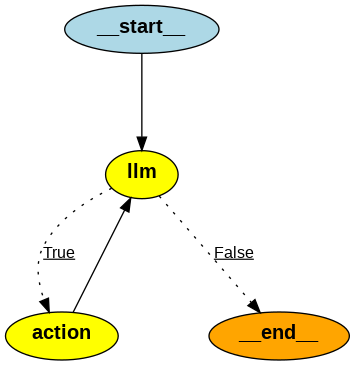

In [ ]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [ ]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_TSn0OEHl6BxakrFOtdkkVzVM', 'type': 'tool_call'}
Back to the model!


In [ ]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TSn0OEHl6BxakrFOtdkkVzVM', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bmwg23TtrcoAC3dHqHfRC22mh2rAG', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5fad3b6a-90ae-4020-bca4-9ea0e9bb4bd9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, '

In [ ]:
result['messages'][-1].content

'The weather forecast for San Francisco, CA on June 27, 2025, is as follows:\n\n- Day: 64°F\n- Night: 52°F\n- Precipitation: 0%\n- Wind: 11 mph\n- UV Index: 11\n\nFor more detailed information and updates, you can visit [WeatherShogun.com](https://weathershogun.com/weather/usa/ca/san-francisco/480/june/2025-06-27).'

In [ ]:
# Reset messages in state manually
clean_state = {"messages": [HumanMessage(content="New question to ask here")]}
result = abot.graph.invoke(clean_state)

In [ ]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
# Reset the messages in the AgentState before invoking the graph
print("AgentState before invoke:", {"messages": messages})
result = abot.graph.invoke({"messages": messages})
print("AgentState after invoke:", result)

AgentState before invoke: {'messages': [HumanMessage(content='What is the weather in SF and LA?', additional_kwargs={}, response_metadata={})]}
Entering take_action...
Tool calls identified: [{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_bufZUKxfQjNf0V6IrIceUG54', 'type': 'tool_call'}, {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_yuti6oysmVvb6WsinmSG8VeM', 'type': 'tool_call'}]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_bufZUKxfQjNf0V6IrIceUG54', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_yuti6oysmVvb6WsinmSG8VeM', 'type': 'tool_call'}
Back to the model!
Tool results generated: [ToolMessage(content='[{\'title\': \'Friday, June 27, 2025. San Francisco, CA - Weather Forecast\', \'url\': \'https://weathershogun.com/weather/u

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 28884 tokens (28813 in the messages, 71 in the functions). Please reduce the length of the messages or functions.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

In [ ]:
# Note, the query was modified to produce more consistent results.
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Entering take_action...
Tool calls identified: [{'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_lpl9p5ohss4bDiMBKjewvjdf', 'type': 'tool_call'}]
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_lpl9p5ohss4bDiMBKjewvjdf', 'type': 'tool_call'}
Back to the model!
Tool results generated: [ToolMessage(content='[{\'title\': \'Super Bowl 2024 Updates: The Kansas City Chiefs win the Super Bowl - NPR\', \'url\': \'https://www.npr.org/2024/02/10/1230621176/super-bowl-58\', \'content\': "Kansas City Chiefs\' tight end #87 Travis Kelce and Kansas City Chiefs\' quarterback #15 Patrick Mahomes hug after winning Super Bowl LVIII against the San Francisco 49ers at Allegiant Stadium in Las Vegas, Nevada, February 11, 2024.\\n\\nThe Kansas City Chiefs win the 2024 Super Bowl, 25-22!\\n\\nThe Kansas City Chiefs have won their third Super Bowl title in five years, and are the first back-to-back NFL cham

In [ ]:
print(result['messages'][-1].content)

1. The Kansas City Chiefs won the Super Bowl in 2024.

2. The headquarters of the Kansas City Chiefs is located in Kansas City, Missouri.

3. The Gross Domestic Product (GDP) of Missouri was reported to be approximately $430 billion in 2023. 

Note: Kansas City, Missouri is part of a metropolitan area that includes both Kansas and Missouri, and the headquarters are specifically in Missouri.
